# multi omic data integration

In [1]:
import os
os.chdir('/home/xli')
os.getcwd()

'/home/xli'

In [2]:
# Data Analysis
import numpy as np
import pandas as pd
from pybedtools import BedTool

# Plot Package
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline


In [33]:
def union_all_features(Path_Features_Folder, summit_or_normal):
    ## find all features inside given path
    Path_Feature_list=[]
    for file in os.listdir(Path_Features_Folder):
        if (file.endswith(".bed")):
            Path_Feature_list.append(Path_Features_Folder+'/'+file)
    
    ## union them all
    i=0
    if (summit_or_normal=='summit'):
        for Path_Feature in Path_Feature_list:
            df_feature = pd.read_csv(Path_Feature,sep="\t")
            if(min(df_feature['pin'])==0):
                print ("ERR: File " + Path_Feature + "has wrong summit, check!")
                exit
            else:
                df_feature['start'] = df_feature['pin']-1
                df_feature['end'] = df_feature['pin']
                feature_add = BedTool.from_dataframe(df_feature)
                if(i==0):
                    feature_union = feature_add
                else:
                    feature_union = feature_union.cat(feature_add,postmerge=False)
                i+=1
    else:
        for Path_Feature in Path_Feature_list:
            feature_add=BedTool(Path_Feature)
            if(i==0):
                feature_union = feature_add
            else:
                feature_union = feature_union.cat(feature_add,postmerge=False)
            i+=1
    return feature_union.sort()

def associated_features_with_genes(feature_target, union_features, number_features_per_gene):
    # Gene Path, Target

    ## Features union
    features_closest_associated=feature_target.closest(union_features, k=number_features_per_gene, d=True, D='a')
    #"a"     Report distance with respect to A.  When A is on the - strand, "upstream" means B has a higher (start,stop).

    #df_features_closest_associated=pd.read_csv(features_20_closest_associated.fn, header=None, sep="\t")
    return features_closest_associated.fn

def features_visualization_on_gene(df_group, gene_name, num_columns_target, fc_label):
    df_inside_gene = df_group.get_group(gene_name) ##
    Gene_Expression_FC = df_inside_gene.iloc[0,4]
    df_inside_gene = df_inside_gene.iloc[:, num_columns_target:]
    ## data inside gene format, actually ignore gene part, then, still 3 should be id.
    df_subgroup_inside_gene = df_inside_gene.iloc[:, 3].str.split('_',  expand=True).groupby([0])
    # group by first part of id, normally is the category
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))

    color=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','black'] 
    ## Maxium 10 features
    boundary_limit=0
    list_item_legend=[]
    list_name_legend=[]
    i=0
    j=0
    ## assuming fifth columns score, is Log2(FC)
    for feature_type in df_subgroup_inside_gene.groups.keys():
        Enlargement_Constant=200
        df_feature_tem = df_inside_gene.loc[df_subgroup_inside_gene.get_group(feature_type).index,:] 
        x_coordinate=df_feature_tem.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
        boundary_limit = max(boundary_limit, max(max(x_coordinate),abs(min(x_coordinate))))
        
        if(feature_type in fc_label):
            if(feature_type=='SE'): Enlargement_Constant=1000              
#############################################################################################
            ### This line is like the fold change = 1 line, 
            ax.plot([-boundary_limit,boundary_limit],[j,j], c=color[i], linestyle='--', lw=1, label=feature_type+"fold_change=1")
#############################################################################################
            df_feature_tem_fc_1 = df_feature_tem[df_feature_tem.iloc[:,4].astype(float)>0]  ## fifth columns is score
            x_coordinate= df_feature_tem_fc_1.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
            y_coordinate= df_feature_tem_fc_1.iloc[:,4].astype(float) ## corresponding to score part
            marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]
            im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+j+0.5, s=marker_size,  marker='^', c=color[i], alpha=0.8)
            list_item_legend.append(im)
            list_name_legend.append(feature_type+'_Up')
#############################################################################################    
            df_feature_tem_fc_less_1 = df_feature_tem[df_feature_tem.iloc[:,4].astype(float)<0]
            x_coordinate= df_feature_tem_fc_less_1.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
            y_coordinate= df_feature_tem_fc_less_1.iloc[:,4].astype(float) ## corresponding to score part
            marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]
            im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+j-0.5, s=marker_size, marker='v' , c=color[i], alpha=0.8)
            list_item_legend.append(im)
            list_name_legend.append(feature_type+'_Down')
            j+=1
            print (j)
####################################################################################
        else:
            #y_coordinate=np.log2(df_feature_tem.iloc[:,4].astype(float))  ## corresponding to score part
            y_coordinate=(df_feature_tem.iloc[:,4].astype(float))
            im=ax.scatter(x_coordinate, y_coordinate, s=Enlargement_Constant, c=color[i],  marker='^')
            list_item_legend.append(im)
            list_name_legend.append(feature_type)
        i+=1
        ## color code +1
####################################################################################
    legend_object = ax.legend(list_item_legend,list_name_legend, loc="upper right", scatterpoints=1,bbox_to_anchor=(0.50,1, 1,0),
            edgecolor='w', borderaxespad=0, fancybox=True, shadow=False,  fontsize=18, labelspacing=1.0)
    x=[-boundary_limit,0,boundary_limit]
    ax.set_xticks(x)
    customized_xticks=[ 'Upstream: '+ str(x[0]) ,'TSS of '+gene_name,'Downstream: +' + str(x[2])]
    ax.set_xticklabels(customized_xticks, fontsize=18)
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_ylabel("Tcf1_Peaks_Strength (Scale: Log2)", fontsize=18)
    #ax.set_ylim(-3,10)
    ax.set_title('Expression Log2(Fold Change): '+ str(Gene_Expression_FC), fontsize=18)
    return None

In [4]:
#Union Features
Path_Features = "/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/Summary_Files"
union_features = union_all_features(Path_Features,'nosummit')
## Prepare Target genes
Path_Target=Path_Features+'/Target/24391_Target_mm9_genes_with_strand.bed'
df_target = pd.read_csv(Path_Target, sep="\t")
df_target['start'] =  df_target['pin'] 
df_target['end'] =  df_target['pin']+1
Feature_Target=BedTool.from_dataframe(df_target).sort()

##Associated by closest 
Path_Associated_featuers = associated_features_with_genes(Feature_Target, union_features, 20)
df_group=pd.read_csv(Path_Associated_featuers, header=None, sep="\t").groupby([3]) # the fourth columns is geneid

/opt/miniconda2/envs/ipykernel_py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1
2


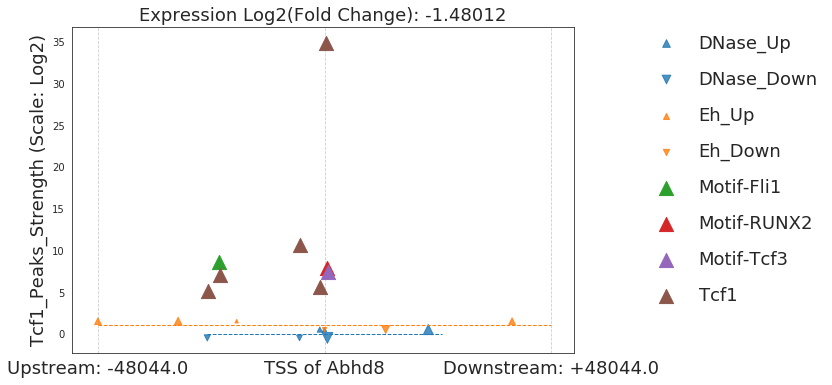

In [38]:
## summit
gene_list=['Ramp3', 'Snhg10', 'Il3ra', 'Cd200', 'App', 'Anxa5', 'Il6ra', 'Cryz', 'Abhd8']

gene_name='Abhd8'
features_visualization_on_gene(df_group, gene_name, len(df_target.columns), ['DNase', 'Eh' , 'SE'])

412057    0.08724679578094098
412063    0.13852097163402802
412068      0.508546252423989
Name: 14, dtype: object
412067     0.0618918898660383
412073    0.30416909767137174
412074     0.2189969482649139
412075    0.23079275346533415
Name: 14, dtype: object
412070    8.550351
Name: 14, dtype: object
412060    7.909513
Name: 14, dtype: object


IndexError: list index out of range

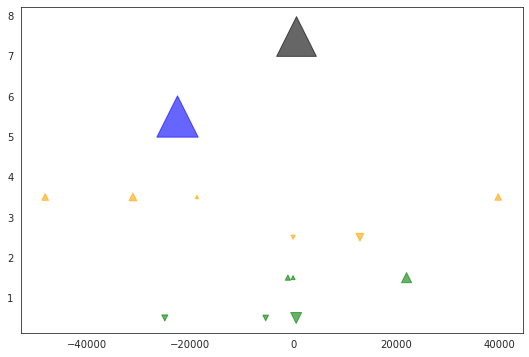

In [25]:
gene_name='Abhd8'
df_inside_gene = df_group.get_group(gene_name).iloc[:,10:]
df_subgroup_inside_gene = df_inside_gene[13].str.split('_',  expand=True).groupby([0])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))

color=["green",'orange',"blue", 'black']
boundary_limit=0
list_item_legend=[]
list_name_legend=[]
i=0

for feature_type in df_subgroup_inside_gene.groups.keys():
    Enlargement_Constant=200
    df_feature_tem = df_inside_gene.loc[df_subgroup_inside_gene.get_group(feature_type).index,:]
    x_coordinate=df_feature_tem[17]
    y_coordinate=df_feature_tem[14]
    boundary_limit = max(boundary_limit, max(max(x_coordinate),abs(min(x_coordinate))))
    if (feature_type=='Tcf1'):
        im=ax.scatter(x_coordinate, y_coordinate, s=Enlargement_Constant, c="red",  marker='^')
        list_item_legend.append(im)
        list_name_legend.append(feature_type)
    else:
        if(feature_type=='SE'):
            Enlargement_Constant=1000
        
        df_feature_tem_fc_1 = df_feature_tem[df_feature_tem[14].astype(float)>0]

        x_coordinate=df_feature_tem_fc_1[17]
        y_coordinate=df_feature_tem_fc_1[14]

        marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]

        im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+2*i+1.5, s=marker_size,  marker='^' , c=color[i], alpha=0.6)
        print (y_coordinate)
        list_item_legend.append(im)
        list_name_legend.append(feature_type+'_Up')
        
        
        
        df_feature_tem_fc_less_1 = df_feature_tem[df_feature_tem[14].astype(float)<0]
        x_coordinate=df_feature_tem_fc_less_1[17]
        y_coordinate=df_feature_tem_fc_less_1[14]
        marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]
        im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+2*i+0.5, s=marker_size, marker='v' , c=color[i], alpha=0.6)
        i+=1## color code +1
        list_item_legend.append(im)
        list_name_legend.append(feature_type+'_Down')

In [20]:
gene_name='Abhd8'

df_group = df_features_closest_associated.groupby([3])
#for group_item in df_group:
df_inside_gene = df_group.get_group(gene_name).iloc[:,10:]
df_subgroup_inside_gene = df_inside_gene[13].str.split('_',  expand=True).groupby([0])


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))

color=["green",'orange',"blue", 'black']
boundary_limit=0
list_item_legend=[]
list_name_legend=[]
i=0

for feature_type in df_subgroup_inside_gene.groups.keys():
    Enlargement_Constant=200
    df_feature_tem = df_inside_gene.loc[df_subgroup_inside_gene.get_group(feature_type).index,:]
    x_coordinate=df_feature_tem[18]
    y_coordinate=df_feature_tem[14]
    boundary_limit = max(boundary_limit, max(max(x_coordinate),abs(min(x_coordinate))))
    if (feature_type=='Tcf1'):
        im=ax.scatter(x_coordinate, y_coordinate, s=Enlargement_Constant, c="red",  marker='^')
        list_item_legend.append(im)
        list_name_legend.append(feature_type)
    else:
        if(feature_type=='SE'):
            Enlargement_Constant=1000
            
        df_feature_tem_fc_1 = df_feature_tem[df_feature_tem[14]>1.0]
        x_coordinate=df_feature_tem_fc_1[18]
        y_coordinate=df_feature_tem_fc_1[14]
        marker_size = [round(x) for x in abs(y_coordinate*Enlargement_Constant)]
        im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+2*i+1.5, s=marker_size,  marker='^' , c=color[i], alpha=0.6)
        list_item_legend.append(im)
        list_name_legend.append(feature_type+'_Up')
        
        
        df_feature_tem_fc_less_1 = df_feature_tem[df_feature_tem[14]<1.0]
        x_coordinate=df_feature_tem_fc_less_1[18]
        y_coordinate=df_feature_tem_fc_less_1[14]
        marker_size = [round(x) for x in abs(y_coordinate*Enlargement_Constant)]
        im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+2*i+0.5, s=marker_size, marker='v' , c=color[i], alpha=0.6)
        i+=1## color code +1
        list_item_legend.append(im)
        list_name_legend.append(feature_type+'_Down')
    
ax.legend(list_item_legend, list_name_legend, scatterpoints=1,loc=0, fontsize=14)
x=[-boundary_limit,0,boundary_limit]
ax.set_xticks(x)
customized_xticks=[ 'Upstream: '+ str(x[0]) ,'TSS of '+gene_name,'Downstream: +' + str(x[2])]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
ax.set_ylim(-3,10)


NameError: name 'df_features_closest_associated' is not defined

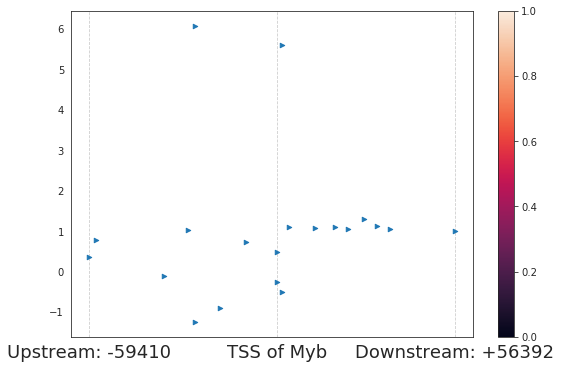

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
df_single_gene = df_group.get_group('Myb')

x_coordinate=df_single_gene[18]
y_coordinate=df_single_gene[14]

im=ax.scatter(x_coordinate, y_coordinate, s=20, cmap='RdBu_r', marker='>', vmin=-3,vmax=3)
#ax.text(0,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)


x=[min(x_coordinate),0,max(x_coordinate)]
ax.set_xticks(x)
customized_xticks=[ 'Upstream: '+ str(x[0]) ,'TSS of Myb','Downstream: +' + str(x[2])]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')


In [82]:
def gene_associated_multi_feature_tcf1(gene_annotation_path, feature_path, feature_RPKM_path, tcf1_feature_path, expression_path, genelist_set_for_plot):
    ## Genes 
    gene_annotation_Bed=BedTool(gene_annotation_path).sort()
    ## Features To be associated
    features_Bed=BedTool(feature_path).sort()
    ## Add Tcf1
    Tcf1_Peak_Bed=BedTool(tcf1_feature_path)
    features_Bed_with_Tcf1=features_Bed.intersect(Tcf1_Peak_Bed,c=True)
    ## Associated Rule report ties
    features_associated=features_Bed_with_Tcf1.closest(gene_annotation_Bed, t='all')
    df_features_associated=pd.read_table(features_associated.fn, header=None)
    ## Group by gene_id
    df_genes_with_features=df_features_associated.groupby(8) ## in some cases, 7 columns is gene_id
    ## add expression
    df_gene_expression=generate_All_Genes(path_of_expression,0)
    ### in here, feature coordinates are seperate file from RPKM
    df_edgeR=pd.read_csv(feature_RPKM_path, sep='\t')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
    
    j=0
    for gene_set_name in genelist_set.keys():
        print gene_set_name
        df_genelist_set=pd.DataFrame({'gene_id':genelist_set[gene_set_name]})
        df_gene_expression_tem=df_gene_expression.merge(df_genelist_set, on='gene_id', how='inner')
        i=0
        for genelist in df_gene_expression_tem.sort_values('log2(fold_change)')['gene_id']:
            if(genelist not in df_features_associated[8].unique()):
                continue
            group=df_genes_with_features.get_group(genelist)
            gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID', 4:'Tcf1'})[['GeneID','Tcf1']], on='GeneID',how='inner').sort_values('logFC')


            x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
            y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
            gene_expression_fc = df_gene_expression[df_gene_expression['gene_id']==genelist]['log2(fold_change)'].values[0]
            im=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc,
                          c=gene_associated_DNase['logFC'],
                        vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
            im_Tcf1=ax.scatter(x_coordinate+i+0.2, y_coordinate+gene_expression_fc, c=gene_associated_DNase['Tcf1'],
                vmin=-1,vmax=1,s=5, cmap='bwr', marker='X')
            ax.text(i,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)
            i+=1
        ax.text(len(genelist_set[genelist_set.keys()[j]])/2, gene_expression_fc-1, 'Genelists: '+ str(len(genelist_set[genelist_set.keys()[j]])), fontsize=12, color='r')   
        j+=1
    im_zero = ax.plot(np.arange(i),np.zeros(i), '--', linewidth=1)
    ax.set_ylabel('Expression  Log$_2$FC', fontsize='18')
    ax.legend([im,im_Tcf1], ['DNase_Site','Tcf1_Binding'], scatterpoints=1,loc=0, fontsize=14)
    fig.colorbar(im,ax=ax)
    return df_features_associated

20025

In [ ]:
df_for_category=df_feature_associated_genes_with_genes
df_group = df_for_category.groupby([8])
genelist_to_be_removed=list()
for group_item in df_group:
    size_group = len(group_item[1])
    if (size_group>1):
        if (len(group_item[1]['SuperEnhancer'].value_counts()) > 1):
            genelist_to_be_removed.append(group_item[0])
print ("Genes with Ambiguity: " + str(len(genelist_to_be_removed)))

In [ ]:
features_closest_associated=features_no_overlap.closest(gene_annotation_Bed, t='all')

In [35]:
from pybedtools import example_bedtool
a = example_bedtool('a.bed')
b = example_bedtool('b.bed')
print (a)
print (b)
print (a.cat(b, postmerge=False))

chr1	1	100	feature1	0	+
chr1	100	200	feature2	0	+
chr1	150	500	feature3	0	-
chr1	900	950	feature4	0	+

chr1	155	200	feature5	0	-
chr1	800	901	feature6	0	+

chr1	1	100	feature1	0	+
chr1	100	200	feature2	0	+
chr1	150	500	feature3	0	-
chr1	900	950	feature4	0	+
chr1	155	200	feature5	0	-
chr1	800	901	feature6	0	+

